In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from solver_so import solver_toa_upgrade_720_sat
from solver_so import solver_toa_upgrade_711_sat
from solver_so import solver_toa_upgrade_630_sat

In [8]:
solvers = [solver_toa_upgrade_720_sat.solver_toa_upgrade_sat_720, solver_toa_upgrade_711_sat.solver_toa_upgrade_sat_711, solver_toa_upgrade_630_sat.solver_toa_upgrade_sat_630]

In [13]:
solvers[0](np.random.random(32))

array([[-1.94376404-0.j        , -1.14880277-1.04799559j,
        -1.14880277+1.04799559j,  0.7086845 +0.j        ,
         0.25276637+0.43857611j,  0.25276637-0.43857611j,
        -0.99516419-0.j        ,  0.54146215+0.j        ,
        -1.0411047 +0.j        ],
       [14.66502721+0.j        , -0.55744272+1.13466829j,
        -0.55744272-1.13466829j, -3.25082242+0.j        ,
        -2.77544323+0.13090377j, -2.77544323-0.13090377j,
        -0.9934186 +0.j        , -1.25417016+0.j        ,
        -1.58977535+0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ]])

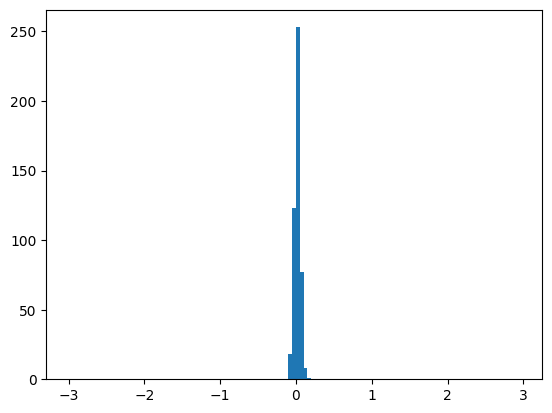

In [48]:
# Synthetic problem

def generate_uvabo_problem(noise_std=0.0, outlier_ratio=0.0):
    r = np.random.random((12,3))
    r -= r[0]
    #r[:,:3] *= 1
    s = np.random.random((40,3))

    q = np.sqrt(np.sum((np.expand_dims(r,1) - np.expand_dims(s,0))**2,axis=2))
    offsets_gt = np.random.rand(1,q.shape[1])*3
    q = q + offsets_gt + noise_std*np.random.randn(*q.shape)
    outlier_idx = np.random.rand(*q.shape) < outlier_ratio
    q[outlier_idx] = np.random.rand(*q.shape)[outlier_idx]*3

    tdoa_df = pd.DataFrame(q)
    tdoa = tdoa_df.to_numpy()
    tdoa_df

    row_choice = np.random.randint(r.shape[0])
    col_choice = np.random.randint(s.shape[0])

    L = np.random.randn(3,3)
    L = np.triu(L).T
    q = np.linalg.solve(L,s[0])

    u = L.T@(r - r[row_choice:row_choice+1]).T
    v = np.linalg.solve(L,(s - s[col_choice:col_choice+1]).T)

    Dsquare = (tdoa - offsets_gt)**2
    a = Dsquare[:,col_choice:col_choice+1]
    b = Dsquare[row_choice:row_choice+1]
    c = Dsquare[row_choice,col_choice]

    u0 = u[:,row_choice:row_choice+1]
    v0 = v[:,col_choice:col_choice+1]
    a = a - 2*u.T@v0 + u0.T@v0
    b = b - 2*u0.T@v + u0.T@v0
    u -= u0
    v -= v0

    diff = (b[:, col_choice] - a[row_choice])

    a += diff/2
    b -= diff/2
    c = b[:, col_choice]

    # print((-2*u.T@v + a + b - c) - Dsquare) # Check that we have zero relaxed residuals in noiseless case
    return tdoa, u, v, a, b, c, offsets_gt, r, s
tdoa, u, v, a, b, c, o, r_gt, s_gt = generate_uvabo_problem(noise_std=0.01)
res = (-2*u.T@v + a + b - c) - (tdoa - o)**2
plt.hist(res.flatten(), bins=np.arange(-3,3,0.05));

In [ ]:
# Find inputs to solvers by looking at matlab comments:
# Hqp, Hqh, comes from the subspace defined by the linear equations we do have. 


In [45]:
# class UvaboSolution():

#     def __init__(self, n_receivers, n_senders, dim=3):
#         u = np.empty((3, n_receivers))
#         u[:] = np.nan
#         self.u = u

#         v = np.empty((3, n_senders))
#         v[:] = np.nan
#         self.v = v

#         a = np.empty((n_receivers,1))
#         a[:] = np.nan
#         self.a = a

#         b = np.empty((1, n_senders))
#         b[:] = np.nan
#         self.b = b

#         o = np.empty((1,n_senders))
#         o[:] = np.nan
#         self.o = o

# from enum import Enum
# from abc import ABC, abstractmethod

# def init_uvab(d):
#     dsquare = d**2
#     doubleCompaction = dsquare - dsquare[0:1,:] - dsquare[:,0:1] + dsquare[0,0]
#     uu,ss,vv = np.linalg.svd(doubleCompaction/-2)
#     u =uu[:,:3].T
#     v = np.diag(ss[:3])@vv[:3,:]
#     a = dsquare[:,0:1] - dsquare[0,0]/2
#     b = dsquare[0:1,:] - dsquare[0,0]/2
#     return u,v,a,b

# class TxoaType(Enum):
#     TOA = 1
#     TDOA = 2
#     COTDOA = 3

# class TxoaProblem():
#     def __init__(self, data, problem_type=TxoaType.TDOA, dim=3):
#         self.data = data
#         self.sol = UvaboSolution(*data.shape, dim=dim)
#         self.problem_type = problem_type
#         self.dim = dim

#     def solve_for_offset(self, solver, tol=0.01, outer_ransac_iters=100, inner_ransac_iters=10):   
#         #sample_subset = lambda : self.data[np.random.permutation(self.data.shape[0])[:solver.get_needed_receivers()],np.random.permutation(self.data.shape[1])[:solver.get_needed_senders()]]

#         most_inliers = -1
#         best_sol = None
#         for _ in range(outer_ransac_iters):
#             mics_choice = np.random.permutation(self.data.shape[0])[:solver.get_needed_receivers()]
#             sound_choice = np.random.permutation(self.data.shape[1])[:solver.get_needed_senders()]
#             data_subset = self.data[mics_choice][:,sound_choice]

#             offsets = solver.solve(data_subset)
#             d = data_subset - offsets
#             u,v,a,b = init_uvab(d)

#             cur_solution = UvaboSolution(*self.data.shape,dim=self.dim)

#             cur_solution.u[:,mics_choice] = u
#             cur_solution.v[:,sound_choice] = v
#             cur_solution.a[mics_choice] = a
#             cur_solution.b[:,sound_choice] = b
#             cur_solution.o[:,sound_choice] = offsets
#             cur_problem = TxoaProblem(self.data, problem_type=self.problem_type, dim=self.dim)
#             cur_problem.sol = cur_solution

#             cur_problem.ransac_expand_to_all_cols(ransac_iter=inner_ransac_iters,tol=tol)

#             res = -2*cur_solution.u.T@cur_solution.v + cur_solution.a + cur_solution.b - (self.data - cur_solution.o)**2

#             if np.sum(np.abs(res) < tol) > most_inliers:
#                 most_inliers = np.sum(np.abs(res) < tol)
#                 best_sol = cur_solution
#                 compaction_row = mics_choice[0]
#                 compaction_col = sound_choice[0]
#         #print(np.median(best_sol.o[0,sound_choice] - offsets_gt[0,sound_choice]))
#         self.sol = best_sol
#         self.compaction_row = compaction_row
#         self.compaction_col = compaction_col

#     def ransac_expand_col(self, new_sound_idx, ransac_iter=10,tol=0.01):
#         needed_eqs = self.dim + 2
#         most_inliers = -1
#         best_sol = None
#         known_mics = np.argwhere(np.logical_not(np.isnan(self.sol.a)))[:,0]

#         for _ in range(ransac_iter):
#             mic_local_choice = np.random.permutation(known_mics.shape[0])[:needed_eqs]
#             M = np.concatenate([2*self.data[known_mics[mic_local_choice],new_sound_idx:new_sound_idx+1],
#                                 -np.ones((needed_eqs,1)),
#                                 -2*self.sol.u[:,known_mics[mic_local_choice]].T,
#                                 np.ones((needed_eqs,1))
#                                 ],axis=1) # variable order is [o_j, o_j^2, v_j, b_j]
#             B = self.data[known_mics[mic_local_choice],new_sound_idx:new_sound_idx+1]**2 - self.sol.a[known_mics[mic_local_choice]]
#             if np.any(np.isnan(M)) or np.any(np.isnan(B)):
#                 print("O no! found none")
#                 continue
#             x_part,_,_,_ = np.linalg.lstsq(M,B,rcond=None)
#             x_hom = np.array([0,1,*([0]*self.dim),1])
#             x_hom = np.expand_dims(x_hom,1)
#             res = x_part[0]**2 - x_part[1]
#             x = x_hom*res + x_part 

#             o_new = x[0]
#             v_new = x[2:5]
#             b_new = x[5]

#             lh = np.expand_dims((self.data[known_mics,new_sound_idx] - o_new)**2,axis=1)
#             rh = -2*self.sol.u[:,known_mics].T@v_new+self.sol.a[known_mics]+b_new

#             res = lh - rh
#             if np.sum(np.abs(res) < tol) > most_inliers:
#                 most_inliers = np.sum(np.abs(res) < tol)
#                 best_sol = (o_new[0], v_new[:,0], b_new[0])
#         self.sol.o[0,new_sound_idx] = best_sol[0]
#         self.sol.v[:,new_sound_idx] = best_sol[1]
#         self.sol.b[0,new_sound_idx] = best_sol[2]

#     def ransac_expand_row(self, new_mic_idx, ransac_iter=10,tol=0.01):
        
#         known_sounds = np.argwhere(np.logical_not(np.isnan(self.sol.b)))[:,1]
#         needed_eqs = self.dim + 1
#         most_inliers = -1
#         best_sol = None
#         for _ in range(ransac_iter):
#             sound_choice = known_sounds[np.random.permutation(known_sounds.shape[0])[:needed_eqs]]
#             M = np.concatenate([-2*self.sol.v[:,sound_choice].T,
#                                 np.ones((needed_eqs,1))
#                                 ],axis=1) # variable order is [o_j, o_j^2, v_j, b_j]
#             B = (self.data[new_mic_idx,sound_choice] - self.sol.o[0,sound_choice])**2 - self.sol.b[0,sound_choice]
#             #B = tdoa[mics_choice[mic_local_choice],new_sound_idx:new_sound_idx+1]**2 - a[mic_local_choice] 
#             if np.any(np.isnan(M)) or np.any(np.isnan(B)):
#                 print("O no! found none")
#                 continue
#             x = np.linalg.solve(M,B)

#             u_new = np.expand_dims(x[:3],axis=1)
#             a_new = x[3]

#             lh = np.expand_dims((self.data[new_mic_idx,known_sounds] - self.sol.o[:,known_sounds])**2,axis=1)
#             rh = -2*u_new.T@self.sol.v[:,known_sounds]+a_new+self.sol.b[:,known_sounds]

#             res = lh - rh
#             if np.sum(np.abs(res) < tol) > most_inliers:
#                 most_inliers = np.sum(np.abs(res) < tol)
#                 best_sol = (u_new, a_new)
#         self.sol.u[:,new_mic_idx] = best_sol[0][:,0]
#         self.sol.a[new_mic_idx] = best_sol[1]

#     def ransac_expand_to_all_cols(self, ransac_iter=10, tol=0.01):
#         known_sounds = np.argwhere(np.logical_not(np.isnan(self.sol.b)))[:,1]
#         for new_sound in np.setdiff1d(np.arange(self.data.shape[1]),known_sounds):
#             self.ransac_expand_col(new_sound,ransac_iter=ransac_iter, tol=tol)
    
#     def ransac_expand_to_all_rows(self, ransac_iter=10, tol=0.01):
#         known_mics = np.argwhere(np.logical_not(np.isnan(self.sol.a)))[:,0]
#         for new_mic in np.setdiff1d(np.arange(self.data.shape[0]),known_mics):
#             self.ransac_expand_row(new_mic,ransac_iter=ransac_iter, tol=tol)
        
#     def get_residuals(self):
#         return (-2*self.sol.u.T@self.sol.v + self.sol.a + self.sol.b) - (self.data - self.sol.o)**2

#     def bundle(self, lr=3e-3, steps=30, tol=0.0001):
#         dtype = torch.float32
#         good_rows = np.logical_not(np.isnan(self.sol.a[:,0]))
#         good_cols = np.logical_not(np.isnan(self.sol.b[0]))
#         u = nn.Parameter(torch.tensor(self.sol.u[:,good_rows],dtype=dtype), requires_grad=False)
#         v = nn.Parameter(torch.tensor(self.sol.v[:,good_cols],dtype=dtype), requires_grad=False)
#         a = nn.Parameter(torch.tensor(self.sol.a[good_rows],dtype=dtype), requires_grad=False)
#         b = nn.Parameter(torch.tensor(self.sol.b[:,good_cols],dtype=dtype))
#         o = nn.Parameter(torch.tensor(self.sol.o[:,good_cols],dtype=dtype), requires_grad=False)
#         data = torch.tensor(self.data[good_rows][:,good_cols],dtype=dtype)
#         optimizer = torch.optim.Adam([u,v,a,b,o],lr=lr)

#         #compute_estimate = lambda u,v,a,b,o : (-2*u.T@v + a + b)**0.5 + o # Had problem with nan values spreading when using this loss space
#         compute_part_estimate = lambda u,v,a,b : (-2*u.T@v + a + b)
        
#         huberloss = torch.nn.HuberLoss(delta=tol)
#         for _ in range(steps):

#             est = compute_part_estimate(u,v,a,b)
#             good_idx = (est ** 0.5 + o).isnan().logical_not()

#             loss = huberloss(est[good_idx],((data - o)**2)[good_idx]) 
#             #print("---")
#             #print(loss)
#             loss += tol*torch.maximum(torch.tensor(0),-est[est.isnan().logical_not()]).mean()
#             #print(loss)

#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
        
#         self.sol.u[:,good_rows] = u.detach().numpy().astype(dtype=self.sol.u.dtype)
#         self.sol.v[:,good_cols] = v.detach().numpy().astype(dtype=self.sol.v.dtype)
#         self.sol.a[good_rows] = a.detach().numpy().astype(dtype=self.sol.a.dtype)
#         self.sol.b[:,good_cols] = b.detach().numpy().astype(dtype=self.sol.b.dtype)
#         self.sol.o[:,good_cols] = o.detach().numpy().astype(dtype=self.sol.o.dtype)

#     def upgrade(self, ransac_iter=100, tol=0.1): # TODO : is it possible to change what row we do the compaction on?? should be
#         u = self.sol.u
#         v = self.sol.v
#         a = self.sol.a
#         b = self.sol.b
        
#         u0 = u[:,self.compaction_row:self.compaction_row+1]
#         v0 = v[:,self.compaction_col:self.compaction_col+1]
#         a = a - 2*u.T@v0 + u0.T@v0
#         b = b - 2*u0.T@v + u0.T@v0
#         u -= u0
#         v -= v0

#         diff = (b[:, self.compaction_col] - a[self.compaction_row])
        
#         a += diff/2
#         b -= diff/2
#         c = b[:, self.compaction_col]

       
        

#         rows_needed = 9
#         # B = ((self.data[:, self.compaction_col:self.compaction_col+1] - self.sol.o[:,self.compaction_col])**2 
#         #      - (self.data[self.compaction_row, self.compaction_col] - self.sol.o[:,self.compaction_col])**2)
#         B = a - c
 
#         M = np.stack([u[0,:]**2, 
#               2*u[0,:]*u[1,:], 
#               2*u[0,:]*u[2,:],
#               u[1,:]**2, 
#               2*u[1,:]*u[2,:],
#               u[2,:]**2, 
#               -2*u[0,:],
#               -2*u[1,:],
#               -2*u[2,:]],axis=1)
        
#         most_inliers = -1
#         best_sol = None
#         for _ in range(ransac_iter):
#             temp = np.random.permutation(self.sol.a.shape[0])
#             mic_choice = temp[temp != self.compaction_row][:rows_needed]

#             sol = np.linalg.solve(M[mic_choice],B[mic_choice])

#             H = np.array([[sol[0,0],sol[1,0],sol[2,0]],
#                     [sol[1,0],sol[3,0],sol[4,0]],
#                     [sol[2,0],sol[4,0],sol[5,0]]
#                     ])
#             q = sol[6:]
#             #u,s,v = np.linalg.svd(np.linalg.inv(H))
#             H_inv = np.linalg.inv(H)
#             # if not np.all(np.linalg.eigvals(H_inv) > 0):
#             #     continue
#             # L = np.linalg.cholesky(H_inv).T
#             L = np.linalg.cholesky(H_inv + np.eye(3)*(-np.linalg.eigvals(H_inv).min() + 1e-5 if np.linalg.eigvals(H_inv).min() <= 0 else 0)).T
#             S = L@v + L@q
#             R = np.linalg.solve(L.T,u)

#             # L = np.linalg.cholesky(H + np.eye(3)*(-np.linalg.eigvals(H).min() + 1e-5 if np.linalg.eigvals(H).min() <= 0 else 0)).T
#             # S = np.linalg.solve(L,v) + q
#             # R = L.T@u

#             est = np.sqrt(np.sum((np.expand_dims(R.T,1) - np.expand_dims(S.T,0))**2,axis=2)) + self.sol.o
#             res = est - self.data
#             n_inliers =np.sum(np.abs(res) < tol)
#             if n_inliers > most_inliers:
#                 most_inliers = n_inliers
#                 best_sol = (R,S)
#         if most_inliers == -1:
#             raise Exception("Did not find positive definite matrix H in all ransac tries")
#         return best_sol

# class OffsetSolver(ABC):

#     @abstractmethod
#     def get_needed_receivers():
#         pass

#     @abstractmethod
#     def get_needed_senders():
#         pass

#     @abstractmethod
#     def solve(data):
#         pass
    
# class OffsetSolver95(OffsetSolver):

#     def get_needed_receivers():
#         return 9
    
#     def get_needed_senders():
#         return 5
    
#     def solve(data):
#         zsquared = data ** 2
#         A = np.concatenate([zsquared[:,1:] - zsquared[:,0:1], -2*data[:,1:], 2*data[:,0:1]],axis=1)
#         u = np.linalg.solve(A, np.ones(9))
#         sols = np.concatenate([u[-1:]/np.sum(u[:4]),u[4:-1]/u[:4]],axis=0)
#         return sols


In [46]:
# tp = TxoaProblem(tdoa)
# tp.solve_for_offset(OffsetSolver95)

# tp.sol.o = offsets_gt
# tp.ransac_expand_to_all_rows()
# plt.figure()
# plt.hist(tp.get_residuals().flatten(),np.arange(-3,3,0.05));